# Input-output properties cells

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import h5py
import json
import numpy as np
import os
from matplotlib import pyplot as plt

rootFolder = '/home/fernando/S1_netpyne/sim/'
os.chdir(rootFolder)

folder = sorted(os.listdir('cell_data/'))
cellnumber=1021
print(folder[cellnumber])

outFolder = rootFolder+'cell_data/'+folder[cellnumber]

# Options
runPlot = 1
compareTraces = 1

durationstim = 1000
delaystim = 300
timesimulation = 1500


with open(outFolder + '/current_amps.dat') as current_file:
    current_content = current_file.read()

print ('File content: %s' % current_content)
holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]

# holding_current= 0
# step3_current = 0


L6_TPC_L1_cADpyr231_2
File content: -0.119019 0.3620628 0.3922347 0.4224066


In [3]:
def loadTemplateName(cellnumber):     
    outFolder = rootFolder+'cell_data/'+folder[cellnumber]
    f = open(outFolder+'/template.hoc', 'r')
    for line in f.readlines():
        if 'begintemplate' in line:
            templatename = str(line)     
    templatename=templatename[:-1]        
    templatename=templatename[14:]
    return templatename

cellName = folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)

In [4]:
os.chdir(rootFolder)

from netpyne import sim
from netpyne import specs
import pickle

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = timesimulation ## Duration of the sim, in ms  
cfg.dt = 0.05
cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = True
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = True
cfg.printPopAvgRates = True

cfg.checkErrors = False

allpops = ['L1_1','L1_2','L1_3','L1_4']

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record


cfg.recordDipole = True
if cfg.recordDipole: cfg.saveDipoleCells = allpops


cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.05            

cfg.simLabel = 'S1detailed'
cfg.saveFolder = '.'
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True           	## Save json file
cfg.saveDataInclude = ['simData', 'net' , 'simConfig', 'netParams'] ## 'simData' , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			##  
cfg.saveCellConns = True		##  

#------------------------------------------------------------------------------
# Analysis and plotting 
#------------------------------------------------------------------------------
cfg.analysis['plotTraces'] = {'include': allpops, 'saveFig': True, 'showFig': False, 'oneFigPer':'trace', 'overlay':False} 		
cfg.analysis['plotDipole'] = {'saveFig': True} 
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.cellmod =  {'L1_1': 'HH_full'}
cfg.cellmod =  {'L1_2': 'HH_full'}
cfg.cellmod =  {'L1_3': 'HH_full'}
cfg.cellmod =  {'L1_4': 'HH_full'}

#------------------------------------------------------------------------------
# Synapses
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Subcellular distribution
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
# with open(outFolder+'/current_amps.dat') as current_file: current_content = current_file.read()

# print 'File content: ', current_content
# holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]

cfg.addIClamp = 1

cfg.IClamp1 = {'pop': 'L1_1', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': holding_current}
cfg.IClamp2 = {'pop': 'L1_2', 'sec': 'soma', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
cfg.IClamp3 = {'pop': 'L1_2', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
cfg.IClamp4 = {'pop': 'L1_3', 'sec': 'soma', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
cfg.IClamp5 = {'pop': 'L1_3', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step2_current}
cfg.IClamp6 = {'pop': 'L1_4', 'sec': 'soma', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
cfg.IClamp7 = {'pop': 'L1_4', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step3_current}


netParams = specs.NetParams()   # object of class NetParams to store the network parameters

netParams.sizeX = 1 # x-dimension (horizontal length) size in um
netParams.sizeY = 1 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 1 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# from __main__ import cfg  # import SimConfig object with params from parent module

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------

cellRule = netParams.importCellParams(label=cellName, somaAtOrigin=False,
    conds={'cellType': cellName, 'cellModel': 'HH_full'},
    fileName='cellwrapper3.py',
    cellName='loadCell',
    cellInstance = True,
    cellArgs={'cellName': cellName, 'cellTemplateName': cellTemplateName})


cellMe = cellName
netParams.renameCellParamsSec(label=cellMe, oldSec='soma_0', newSec='soma')              
for secname2 in netParams.cellParams[cellMe]['secLists'].keys():
    if 'soma_0' in netParams.cellParams[cellMe]['secLists'][secname2]:
        print(cellMe,secname2,netParams.cellParams[cellMe]['secLists'][secname2][0])
        netParams.cellParams[cellMe]['secLists'][secname2][0] = 'soma'   
        
#-----------------------------------------------------------------------------------#

axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['soma']['geom']['pt3d'][-1]
axon_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam']
axon_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L']

netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                  (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                  (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'][-1]
axon1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam']
axon1_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L']

netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                  (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                  (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)]

#-----------------------------------------------------------------------------------#
# for section in netParams.cellParams[cellMe]['secLists']['all']:
#     if 'ions' in netParams.cellParams[cellMe]['secs'][section].keys():
#         if 'ca' in netParams.cellParams[cellMe]['secs'][section]['ions'].keys():
#             netParams.cellParams[cellMe]['secs'][section]['ions']['ca']['o'] = cfg.cao_secs                   
         
#     randRotationAngle = np.pi/2.0  # rand.uniform(0, 6.2832)  #    

#     #  Rotate the cell about the Z axis
#     if 'axon' not in section:
#         for ipt, pt3d in enumerate(netParams.cellParams[cellMe]['secs'][section]['geom']['pt3d']):                
#             x = pt3d[0]
#             z = pt3d[2]
#             c = np.cos(randRotationAngle)
#             s = np.sin(randRotationAngle)        

#             netParams.cellParams[cellMe]['secs'][section]['geom']['pt3d'][ipt][0] = x * c - z * s
#             netParams.cellParams[cellMe]['secs'][section]['geom']['pt3d'][ipt][2] = x * s + z * c

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
netParams.popParams['L1_1'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['L1_2'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['L1_3'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['L1_4'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}
        
# sim.createSimulateAnalyze(netParams, cfg)

	1 
	1 
	1 
cADpyr231_L6_TPC_L1_1856ba2db5[0]
L6_TPC_L1_cADpyr231_2 all soma_0
L6_TPC_L1_cADpyr231_2 somatic soma_0


In [5]:
for typeinfo in ['geom', 'topol', 'mechs', 'ions']:
    print(netParams.cellParams[cellMe]['secs']['dend_0'][typeinfo])
    print(netParams.cellParams[cellMe]['secs']['axon_0'][typeinfo])
    print(netParams.cellParams[cellMe]['secs']['axon_1'][typeinfo])
    print()

{L: 14.038831323261096, nseg: 1, diam: 1.4422118342541752, Ra: 100.0, cm: 2.0, pt3d: [(-6.11998987197876, -0.939054012298584, 5.714799880981445, 1.5800000429153442), (-7.268439769744873, -1.1152700185775757, 6.787230014801025, 1.5800000429153442), (-9.829000473022461, 0.03223180025815964, 6.481130123138428, 1.5800000429153442), (-9.942359924316406, 0.08303429931402206, 6.4675798416137695, 1.5800000429153442), (-12.57349967956543, 1.2621699571609497, 6.153039932250977, 1.340000033378601), (-16.843900680541992, 3.1759300231933594, 5.642549991607666, 1.340000033378601), (-18.456300735473633, 3.8985300064086914, 5.44980001449585, 1.340000033378601), (-18.568500518798828, 3.951590061187744, 5.435140132904053, 1.340000033378601)]}
{L: 30.0, nseg: 1, diam: 0.7566299863696756, Ra: 100.0, cm: 1.0, pt3d: [(-8.657071113586426, -1.8898091316223145, 0.9972096085548401, 0.7566299863696756), (-8.657071113586426, 13.110190868377686, 0.9972096085548401, 0.7566299863696756), (-8.657071113586426, 28.1101

In [6]:
# axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['soma']['geom']['pt3d'][-1]
# axon_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam']
# axon_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L']

# netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
#                                                                   (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
#                                                                   (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

# axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'][-1]
# axon1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam']
# axon1_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L']

# netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
#                                                                   (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
#                                                                   (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)]


Start time:  2022-09-20 17:18:23.364249

Creating network of 4 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop L1_1, on node 0, 
Instantiated 1 cells of population L1_1
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=1) of pop L1_2, on node 0, 
Instantiated 1 cells of population L1_2
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=2) of pop L1_3, on node 0, 
Instantiated 1 cells of population L1_3
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=3) of pop L1_4, on node 0, 
Instantiated 1 cells of population L1_4
  Number of cells on node 0: 4 
  Done; cell creation time = 0.15 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Added IClamp1 IClamp to cell gid=0, sec=soma, loc=0.5, delay=300, dur=1000, amp=-0.119019
  Added IClamp2 IClamp to cell gid=1, sec=som

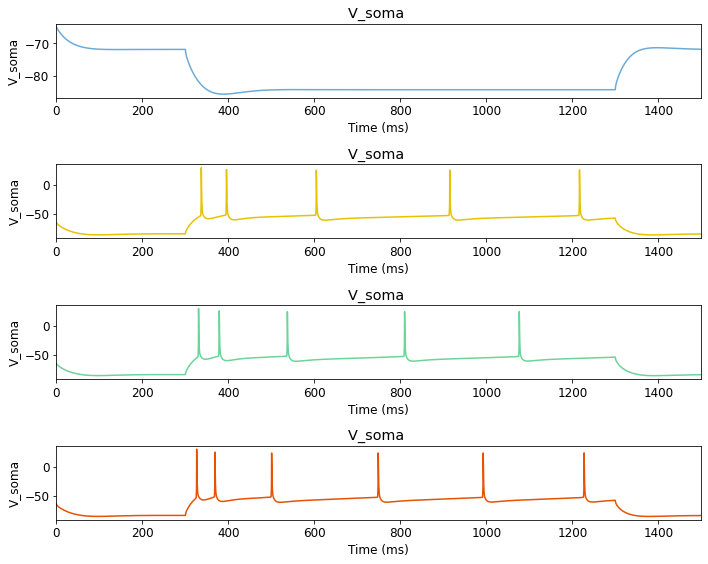

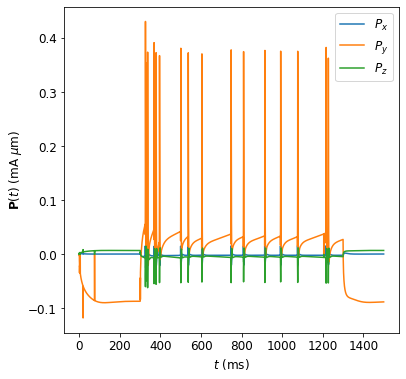

  Done; plotting time = 0.97 s

Total time = 171.91 s


In [7]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc

Plotting recorded cell traces ... trace


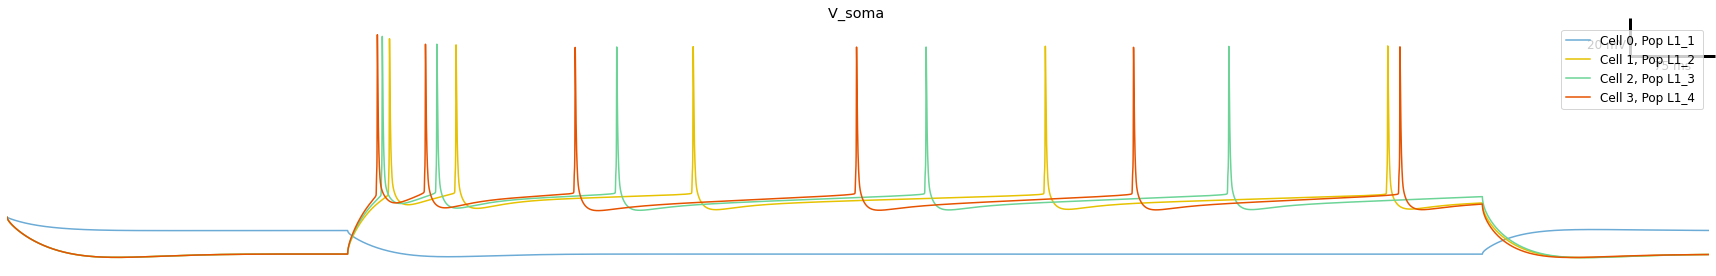

In [8]:
sim.analysis.plotTraces(timeRange=[0,1500], oneFigPer='trace', axis=False, overlay= True, figSize=(24, 4));

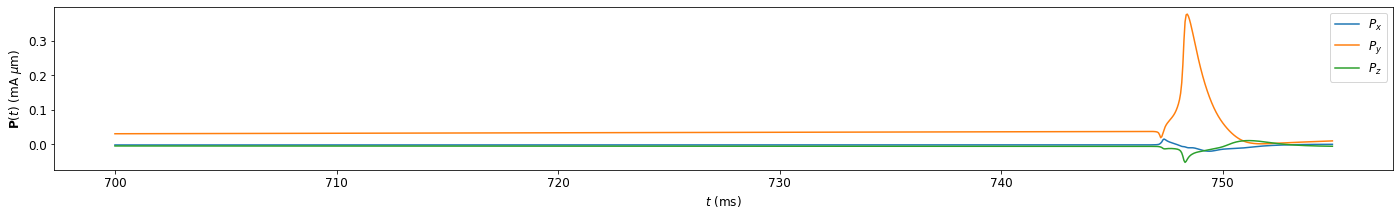

In [9]:
sim.analysis.plotDipole(showCell=0, timeRange=[700,755], dpi=300, figSize=(24, 3))

In [10]:
# sim.analysis.plotDipole(showCell=2, timeRange=[750,800], dpi=300, figSize=(24, 3))

In [11]:
netParams.cellParams.keys()

odict_keys(['L6_TPC_L1_cADpyr231_2'])

In [12]:
sim.net.cells[0].secs['soma'].mechs

{CaDynamics_E2: {gamma: 0.000996, decay: 873.498863, depth: 0.1, minCai: 0.0001}, Ca_HVA: {gCa_HVAbar: 0.000459}, Ca_LVAst: {gCa_LVAstbar: 0.005592}, Ih: {gIhbar: 8e-05}, NaTs2_t: {gNaTs2_tbar: 0.976885}, SK_E2: {gSK_E2bar: 0.003869}, SKv3_1: {gSKv3_1bar: 0.072929}, pas: {g: 3e-05, e: -75.0}, _repr_mimebundle_: {}}

In [13]:
sim.net.cells[0].secs['dend_0']

{mechs: {Ih: {gIhbar: 8e-05}, pas: {g: 3e-05, e: -75.0}}, geom: {L: 14.038831323261096, nseg: 1, diam: 1.4422118342541752, Ra: 100.0, cm: 2.0, pt3d: [(-6.11998987197876, -0.939054012298584, 5.714799880981445, 1.5800000429153442), (-7.268439769744873, -1.1152700185775757, 6.787230014801025, 1.5800000429153442), (-9.829000473022461, 0.03223180025815964, 6.481130123138428, 1.5800000429153442), (-9.942359924316406, 0.08303429931402206, 6.4675798416137695, 1.5800000429153442), (-12.57349967956543, 1.2621699571609497, 6.153039932250977, 1.340000033378601), (-16.843900680541992, 3.1759300231933594, 5.642549991607666, 1.340000033378601), (-18.456300735473633, 3.8985300064086914, 5.44980001449585, 1.340000033378601), (-18.568500518798828, 3.951590061187744, 5.435140132904053, 1.340000033378601)]}, topol: {parentSec: 'soma', parentX: 0.5, childX: 0.0}, hObj: compartCell_L6_TPC_L1_cADpyr231_2_HH_full_0.dend_0, _repr_mimebundle_: {}}

In [14]:
sim.net.cells[0].secs['soma'].geom.pt3d[10]

(-0.5439015626907349,
 -0.7488160133361816,
 0.05467633530497551,
 15.675286293029785)

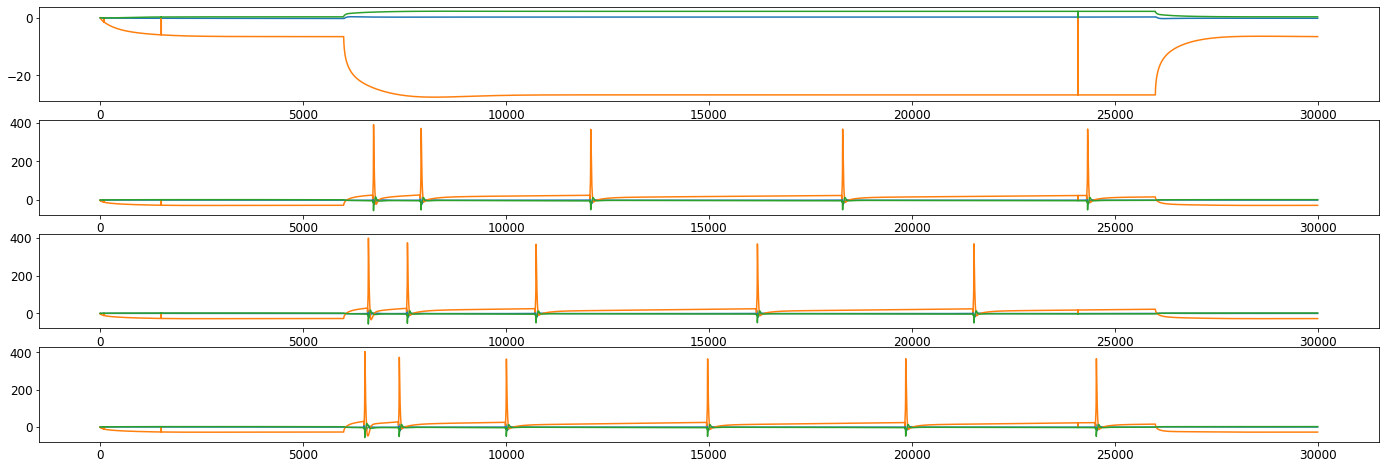

In [15]:
import matplotlib.pyplot as plt
figSize = (24,8)
fig = plt.figure(figsize=figSize)  # Open a new figure
for c in range(4):
    plt.subplot(4, 1, c+1)
    plt.plot(sim.simData['dipoleCells'][c])
# plt.xlim(15400,15450)

Plotting 3D cell shape ...


(<Figure size 640x480 with 2 Axes>, {})

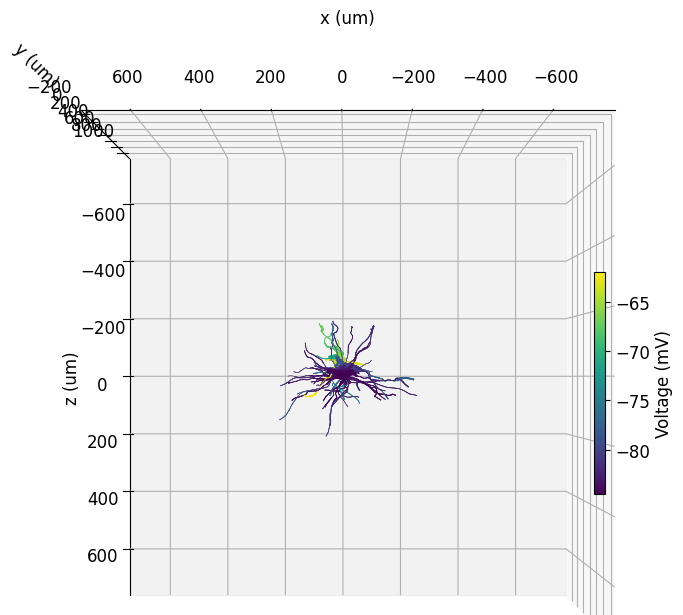

In [16]:
sim.analysis.plotShape(showFig=True,cvar='voltage',dist=0.55,elev=180,azim=-270,axisLabels=True)

Plotting 3D cell shape ...


(<Figure size 640x480 with 2 Axes>, {})

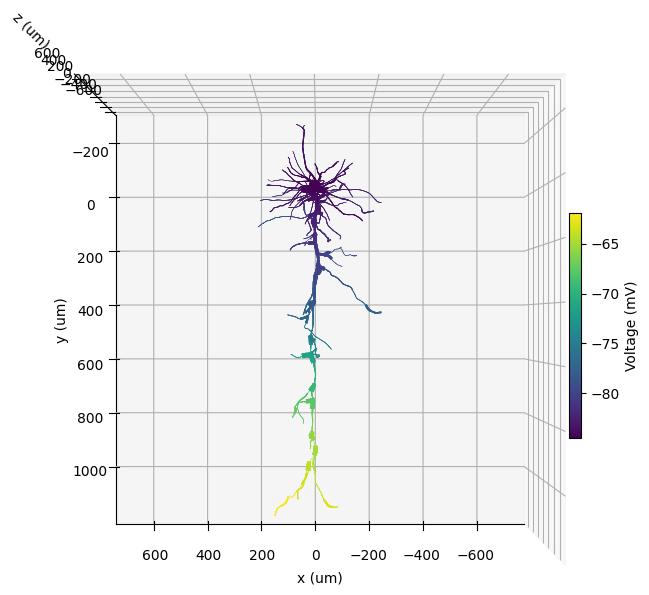

In [17]:
sim.analysis.plotShape(showFig=True,cvar='voltage',azim=-270,axisLabels=True)